In [ ]:
from datetime import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import typing as tp
from warnings import filterwarnings
from sklearn.ensemble import RandomForestRegressor
import xgboost
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

sns.set(palette='Set2', font_scale=1.3)
filterwarnings('ignore')

## Сведение задачи прогнозирования временного ряда к регрессии
## Различные ML модели 

### Задача
Рассмотрим [датасет](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) с kaggle соревнования по прогнозированию спроса на товары. Это довольно простой и чистый датасет. Попробуем на нем разные подходы к прогнозированию временных рядов.

In [ ]:
data = pd.read_csv('demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Как мы видим, датасет содержит информацию о магазинах, товарах и продажах. Выберем первый магазин и первый товар и будем предсказывать спрос на выбранный товар в данном магазине, используя последний год для сравнения моделей.

Выделим соотвествущие данные из датасета.

In [ ]:
# Задаем магазин и продукт
store, item = 1, 1

# Выделяем только те данные, которые относятся к данному магазину и продукту
data = data[(data['store'] == store) & (data['item'] == item)]

# Дату уставнавливаем как индекс
data = data.set_index('date')

# Выделяем данные о продажах
data = data['sales']

### Данные
Разделим данные на трейн и тест для обучения и тестирования результатов соотвественно. На тест отправляем данные за последний год.

In [ ]:
test_size = 365
data_train = data.iloc[: -test_size]
data_test  = data.iloc[-test_size:]

Визуализируем полученные данные. Визуализировать данные нужно с самого начала. Это помогает провалидировать данные и выделить некоторые закономерности.

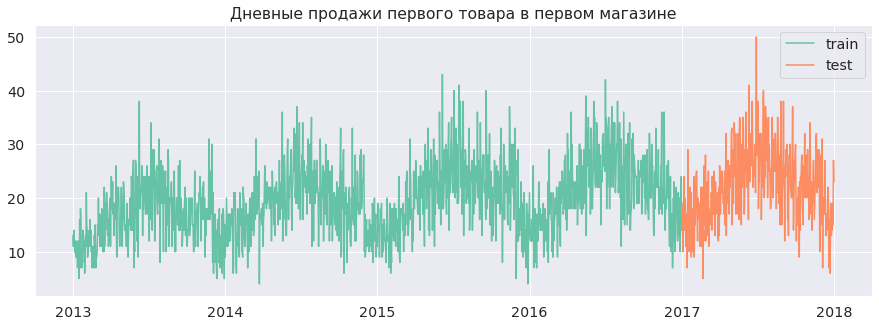

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('Дневные продажи первого товара в первом магазине')
plt.plot(data_train, label='train')
plt.plot(data_test, label='test')
plt.legend();

Видно, что данные обладают годичной сезонностью. Посмотрим теперь, есть ли недельная сезонность.

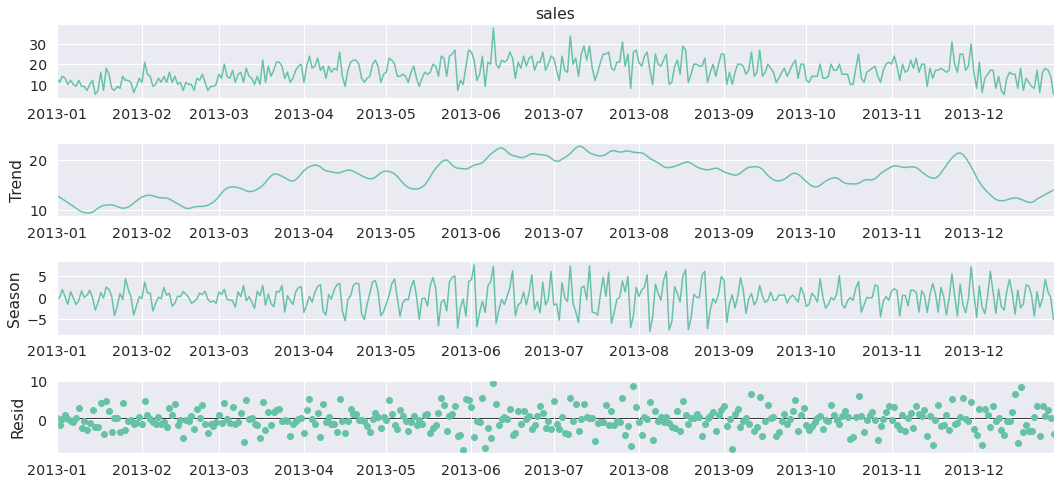

In [ ]:
result = STL(data_train[:364], period=7).fit()
result.plot();

Недельная сезонность есть, но с некоторыми шумами.

### Метрики
Теперь веренмся к самой задаче. Прежде чем ее решать, зададим метрики по которым мы будем определять, какая из моделей лучше: MSE, MAE, MAPE. Напишем функцию, которая будет считать качество моеделей.

In [ ]:
compare_table = None


def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    """
    Добавляет новую строчку в таблицу compare_table с результатами текущей модели.
    Если ранее модель была уже добавлена в таблицу, то старая строчка перезапишется на новую.
    
    Параметры:
    - method: имя модели.
    - y_true: истинные значения.
    - y_forecast: предсказанные значения.
    """
    
    # Обращаемся к глобальной переменной
    global compare_table
    
    # Считаем метрики
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table


def mean_absolute_percentage_error(y_true, y_pred) -> float: 
    """Считает MAPE для y_true и y_pred"""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Простая модель / baseline
Для начала сделаем некоторую эмпирическую модель. Она будет считать среднее за каждый год с учетом дней недели. Полученное среднее как раз будет являться прогнозом на будущее.

In [ ]:
temp_data = pd.DataFrame(data_train)
temp_data['weekofyear'] = data_train.index.weekofyear
temp_data['dayofweek'] = data_train.index.dayofweek
mean_sales = temp_data.groupby(['weekofyear', 'dayofweek'])['sales'].mean()
display(mean_sales)

simple_prediction = []
for index in data_test.index:
    simple_prediction.append(mean_sales.loc[(index.weekofyear, index.dayofweek)])

weekofyear  dayofweek
1           0             8.666667
            1            12.750000
            2            12.000000
            3            12.750000
            4            13.750000
                           ...    
53          2            15.000000
            3            18.000000
            4            21.000000
            5            13.000000
            6            12.000000
Name: sales, Length: 371, dtype: float64

Отобразим полученные результаты.

In [ ]:
def plot_results(y_to_train, y_to_test, y_forecast):
    """
        Функция для визуализации временного ряда и предсказания.
        
        Параметры:
            - y_to_train: pd.Series
                Временной ряд, на котором обучалась модель.
            - y_to_test: pd.Series
                Временной ряд, который предсказывает модель.
            - y_forecast: array
                Предсказания модели.
            - plot_conf_int: bool 
                Надо ли строить предсказательного интервал.
            - left_bound: array
                Левая граница предсказательного интервала.
            - right_bound: array
                Правая граница предсказательного интервала.
    """

    plt.figure(figsize=(15, 5))
    plt.title('Дневные продажи объекта 1 в магазине 1', fontsize=15)
    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')
    plt.legend()
    plt.show()

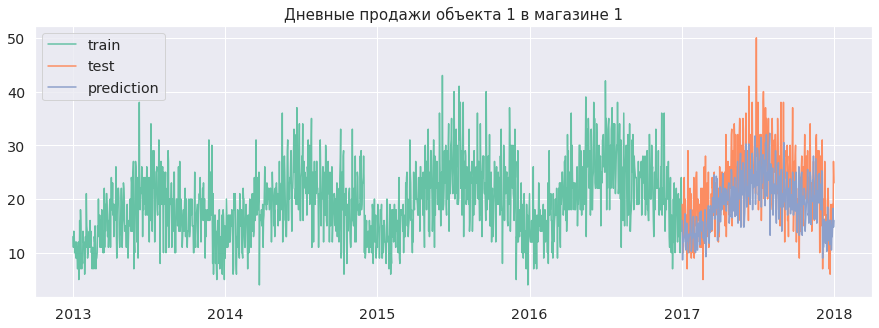

In [ ]:
plot_results(data_train, data_test, simple_prediction)

Для простой модели выглядит очень даже неплохо. Посчитаем метрики и сохраним результат.

In [ ]:
add_results_in_comparison_table('Simple mean model', data_test, simple_prediction)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,21.794923


### Работа с признаками 1
Далее мы будем работать со страндартными моделями регрессии из машинного обучения. Вспомним из теоретической части занятия,какие признаки нужно подавать в модель, чтобы она могла работать с временным рядом.
 ____
 

Для начала преобразуем дату, выделив из даты день, месяц, год и т.д. Для этого будем использовать функцию ниже.

In [ ]:
def create_date_features(date):
    """Создает фичи из даты"""
    
    row = {}
    row['dayofweek'] = date.dayofweek
    row['quarter'] = date.quarter
    row['month'] = date.month
    row['year'] = date.year
    row['dayofyear'] = date.dayofyear
    row['dayofmonth'] = date.day
    row['weekofyear'] = date.weekofyear
    return row

С помощью следующей функции создадим датасет для обучения.

In [ ]:
def create_only_date_train_features(y_series):
    """
        Создает обучающий датасет из признаков, полученных из дат для y_series
    """
    
    time_features = pd.DataFrame([create_date_features(date) for date in y_series.index])
    return time_features, y_series

In [ ]:
X_train, y_train = create_only_date_train_features(data_train)
display(X_train.head())
display(y_train.head())

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,1,1,2013,1,1,1
1,2,1,1,2013,2,2,1
2,3,1,1,2013,3,3,1
3,4,1,1,2013,4,4,1
4,5,1,1,2013,5,5,1


date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Name: sales, dtype: int64

Подумаем о том, как мы будем предсказывать в будущем. Мы рассматривали три стратегии. Какие это были стратегии?
___

В данном случае опробуем рекурсивную стратегию. Она не требует большого количества моделей, как другие стратегии, однако обычно точность у таких моделей оказывается немного хуже.

In [ ]:
def recursive_prediction(model, test_dates, y_to_train, features_creation_function):
    """
    Функция для рекурсивного предсказания для дат, указанных в test_dates.
    
    Параметры:
        - model
            МЛ-модель.
        - test_dates
            массив с датами, в которые надо сделать предсказания.
        - features_creation_function
            функция для создания тестовых признаков
    """
    predictions = []
    previous_y = list(y_to_train)
    
    
    for date in test_dates:
        row = features_creation_function(date, previous_y)
        curr_test = pd.DataFrame([row])
        curr_prediction = model.predict(curr_test)[0]
        previous_y.append(curr_prediction)
        predictions.append(curr_prediction)
    return np.array(predictions)

Попробуем несколько моделей для решения нашей задачи регрессии. Вспомним, какие модели бывают.
___



Попробуем метод `RandomForest`. Обучим модель.

In [ ]:
%%time
random_forest = RandomForestRegressor(n_estimators=300)
random_forest.fit(X_train, y_train)

CPU times: user 1.15 s, sys: 7.61 ms, total: 1.16 s
Wall time: 1.16 s


RandomForestRegressor(n_estimators=300)

Получим предсказания.

In [ ]:
random_forest_predictions = recursive_prediction(
    random_forest, data_test.index, data_train, 
    lambda date, previous_y: create_date_features(date)
)

Отобразим результаты.

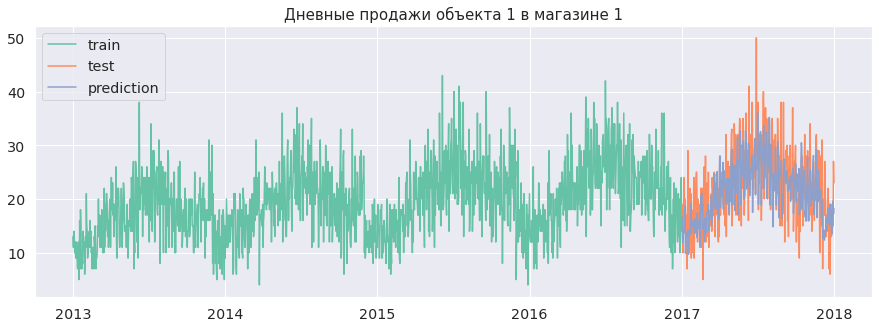

In [ ]:
plot_results(data_train, data_test, random_forest_predictions)

Даже по графику уже видно, что модель на тесте стала ближе к реальным данным. Посчитаем метрики.

In [ ]:
add_results_in_comparison_table('RandomForest', data_test, random_forest_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,21.794923
1,RandomForest,28.391523,4.211826,21.315196


Наконец опробуем `XGBoost`.

In [ ]:
%%time
xgboost_ = xgboost.XGBRegressor()
xgboost_.fit(X_train, y_train, verbose=False)

CPU times: user 1e+03 ms, sys: 28.2 ms, total: 1.03 s
Wall time: 144 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Заметим, что XGBoost работает значительно быстрее RandomForest в предыдущем примере. Это может быть важно для онлайн подхода.

In [ ]:
xgb_predictions = recursive_prediction(
    xgboost_, data_test.index, data_train, 
    lambda date, previous_y: create_date_features(date)
)

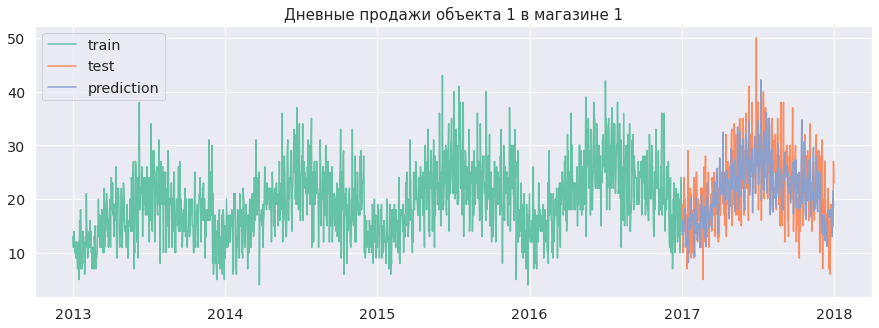

In [ ]:
plot_results(data_train, data_test, xgb_predictions)

In [ ]:
add_results_in_comparison_table('XGBoost', data_test, xgb_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,21.794923
1,RandomForest,28.391523,4.211826,21.315196
2,XGBoost,29.840906,4.426807,22.585702


Однако, как бы это не удивляло, но XGBoost с дефолтными параметрами оказался по качеству хуже, чем RandomForest.

### Работа с признаками 2
Поработаем еще с признаками. На этот раз добавим сдвиги по времени. Таким образом модель сможет использовать информацию из прошлого, для составления прогноза на будущее.

In [ ]:
def create_date_and_shifted_train_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1
):
    """
    Создает обучающий датасет из признаков, полученных из дат и значений ряда ранее.
    При этом используются значения ряда со сдвигами на неделю и год назад.
    """
    
    curr_df, y = create_only_date_train_features(y_series)
    curr_df.index = y_series.index
    for shift in range(1, shifts + 1):
        curr_df[f'shift_{shift}'] = y_series.shift(shift, axis=0)
    for shift in range(1, week_seasonal_shifts + 1):
        curr_df[f'week_seasonal_shift_{shift}'] = y_series.shift(shift * 7, axis = 0)
    for shift in range(1, year_seasonal_shifts + 1):
        curr_df[f'year_seasonal_shift_{shift}'] = y_series.shift(shift * 365, axis = 0)
    y = y_series
    
    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y

Также зададим функцию для того, чтобы на получать аналогичные признаки на тесте.

In [ ]:
def date_and_shift_features_generator_for_test(date, previous_y):
    """Функция создания признаков из дат исдвигов ряда для тестовых дат"""
    
    row = create_date_features(date)
    for shift in range(1, SHIFT + 1):
        row[f'shift_{shift}'] = previous_y[-1 * shift]
    for shift in range(1, WEEK_SHIFT + 1):
        row[f'week_seasonal_shift_{shift}'] = previous_y[-1 * shift * 7]
    for shift in range(1, YEAR_SHIFT + 1):
        row[f'year_seasonal_shift_{shift}'] = previous_y[-1 * shift * 365]
    return row

Зададим сами сдвиги.

In [ ]:
SHIFT = 5
WEEK_SHIFT = 2
YEAR_SHIFT = 1

Получим новые признаки.

In [ ]:
X_train, y_train = create_date_and_shifted_train_features(
    data_train, 
    shifts=SHIFT, 
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT
)

In [ ]:
X_train.head(5)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,shift_1,shift_2,shift_3,shift_4,shift_5,week_seasonal_shift_1,week_seasonal_shift_2,year_seasonal_shift_1
date,,,,,,,,,,,,,,,
2014-01-01,2,1,1,2014,1,1,1,15.0,5.0,14.0,17.0,18.0,6.0,18.0,13.0
2014-01-02,3,1,1,2014,2,2,1,9.0,15.0,5.0,14.0,17.0,16.0,7.0,11.0
2014-01-03,4,1,1,2014,3,3,1,14.0,9.0,15.0,5.0,14.0,18.0,13.0,14.0
2014-01-04,5,1,1,2014,4,4,1,11.0,14.0,9.0,15.0,5.0,17.0,11.0,13.0
2014-01-05,6,1,1,2014,5,5,1,20.0,11.0,14.0,9.0,15.0,14.0,9.0,10.0


In [ ]:
%%time
shifted_features_random_forest = RandomForestRegressor(n_estimators=300)
shifted_features_random_forest.fit(X_train, y_train)

CPU times: user 1.67 s, sys: 28 ms, total: 1.7 s
Wall time: 1.7 s


RandomForestRegressor(n_estimators=300)

In [ ]:
shifted_features_random_forest_predictions = recursive_prediction(
    shifted_features_random_forest, 
    data_test.index, 
    data_train, 
    date_and_shift_features_generator_for_test
)

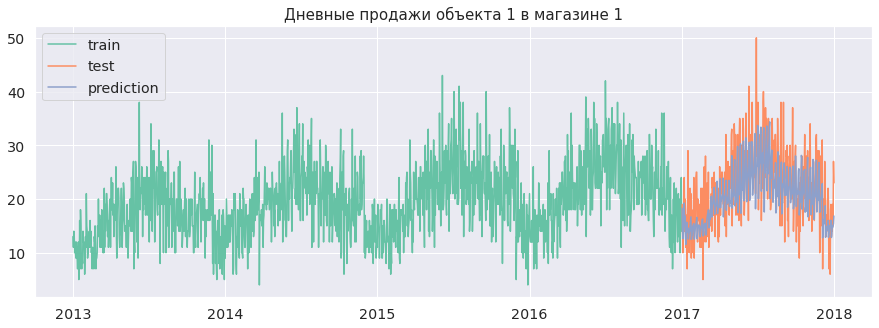

In [ ]:
plot_results(
    data_train, 
    data_test, 
    shifted_features_random_forest_predictions, 
)

Тяжело сказать, улучшился результат или нет.

In [ ]:
add_results_in_comparison_table('RandomForest + shift features', 
                                data_test, shifted_features_random_forest_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,21.794923
1,RandomForest,28.391523,4.211826,21.315196
2,XGBoost,29.840906,4.426807,22.585702
3,RandomForest + shift features,26.486008,4.081836,19.712467


Хотя по графику это не заметно, но результаты модели оказались значительно лучше, чем раньше.

Попробуем снова XGBoost.

In [ ]:
%%time
shifted_features_xgboost = xgboost.XGBRegressor()
shifted_features_xgboost.fit(X_train, y_train, verbose=False)

CPU times: user 1.01 s, sys: 4.19 ms, total: 1.01 s
Wall time: 139 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
shifted_features_xgb_predictions = recursive_prediction(
    shifted_features_xgboost, 
    data_test.index, 
    data_train, 
    date_and_shift_features_generator_for_test
)

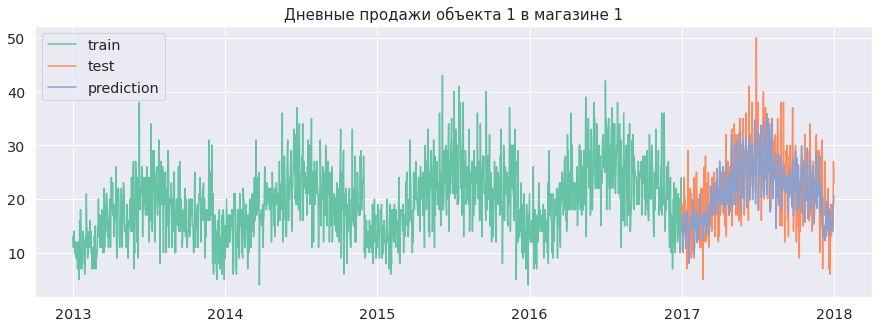

In [ ]:
plot_results(
    data_train, 
    data_test, 
    shifted_features_xgb_predictions, 
)

По графику есть ощущение, что XGBoost отработал лучше.

In [ ]:
add_results_in_comparison_table('XGBoost + shift features', 
                                data_test, shifted_features_xgb_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,21.794923
1,RandomForest,28.391523,4.211826,21.315196
2,XGBoost,29.840906,4.426807,22.585702
3,RandomForest + shift features,26.486008,4.081836,19.712467
4,XGBoost + shift features,27.043359,4.162855,21.213755


Однако метрика, показывает другие результаты.

### Работа с признаками 3
Еще немного поэксперементируем с признаками.

In [ ]:
def create_date_shifted_and_rolling_train_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1
):
    """
        Создает обучающий датасет из признаков, полученных из дат и значений ряда ранее.
        Используются занчения ряда со сдвигами на неделю и год назад.
        Также добавлены признаки скользящего среднего.
    """
    
    curr_df, y = create_date_and_shifted_train_features(
        y_series, 
        shifts=shifts, 
        week_seasonal_shifts=week_seasonal_shifts, 
        year_seasonal_shifts=year_seasonal_shifts
    )
    
    # Важно! значения скользящего окна надо сдивнуть на 1 вправо, 
    # иначе вы будете использовать при обучении текущее значение ряда.
    curr_df['rolling_mean'] = y_series.rolling(shifts, min_periods=1).mean().shift(1, axis = 0)
    curr_df['rolling_max'] = y_series.rolling(shifts, min_periods=1).max().shift(1, axis = 0)
    curr_df['rolling_min'] = y_series.rolling(shifts, min_periods=1).min().shift(1, axis = 0)
    
    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y

In [ ]:
def date_shifted_and_rolling_features_generator_for_test(date, previous_y):
    """Функция создания признаков из дат исдвигов ряда для тестовых дат"""
    
    row = date_and_shift_features_generator_for_test(date, previous_y)
    row['rolling_mean'] = np.mean(previous_y[-SHIFT:])
    row['rolling_max'] = np.max(previous_y[-SHIFT:])
    row['rolling_min'] = np.min(previous_y[-SHIFT:])
    return row

In [ ]:
X_train, y_train = create_date_shifted_and_rolling_train_features(
    data_train, 
    shifts=SHIFT, 
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT)

In [ ]:
advanced_features_random_forest = RandomForestRegressor(n_estimators=300)
advanced_features_random_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [ ]:
advanced_features_random_forest_predictions = recursive_prediction(
    advanced_features_random_forest, 
    data_test.index, 
    data_train, 
    date_shifted_and_rolling_features_generator_for_test
)

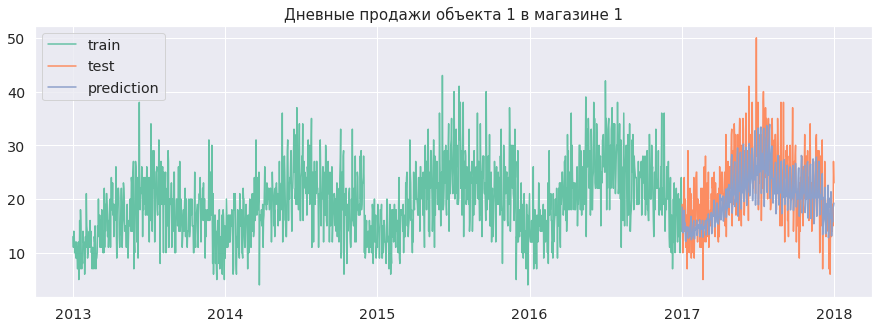

In [ ]:
plot_results(
    data_train, 
    data_test, 
    advanced_features_random_forest_predictions, 
)

In [ ]:
add_results_in_comparison_table('RandomForest, advanced features', 
                                data_test, advanced_features_random_forest_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,21.794923
1,RandomForest,28.391523,4.211826,21.315196
2,XGBoost,29.840906,4.426807,22.585702
3,RandomForest + shift features,26.486008,4.081836,19.712467
4,XGBoost + shift features,27.043359,4.162855,21.213755
5,"RandomForest, advanced features",26.292108,4.057918,19.587309


Результаты стали даже немножеко хуже.

In [ ]:
advanced_features_xgboost = xgboost.XGBRegressor()
advanced_features_xgboost.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
advanced_features_xgb_predictions = recursive_prediction(
    advanced_features_xgboost, 
    data_test.index, 
    data_train, 
    date_shifted_and_rolling_features_generator_for_test
)

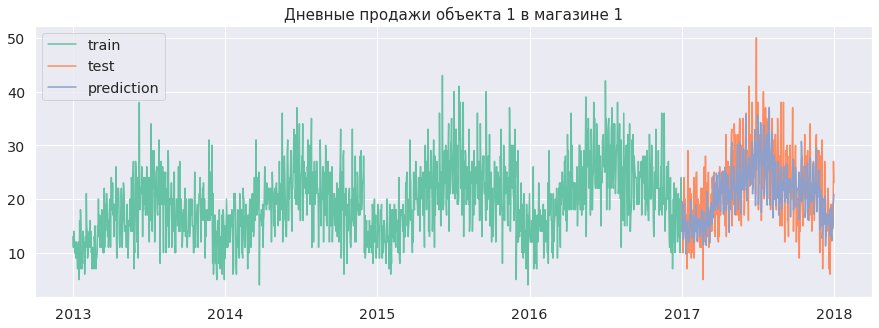

In [ ]:
plot_results(
    data_train, 
    data_test, 
    advanced_features_xgb_predictions, 
)

In [ ]:
add_results_in_comparison_table('XGBoost, advanced features', 
                                data_test, advanced_features_xgb_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,21.794923
1,RandomForest,28.391523,4.211826,21.315196
2,XGBoost,29.840906,4.426807,22.585702
3,RandomForest + shift features,26.486008,4.081836,19.712467
4,XGBoost + shift features,27.043359,4.162855,21.213755
5,"RandomForest, advanced features",26.292108,4.057918,19.587309
6,"XGBoost, advanced features",27.605066,4.060974,20.211705


Добавление более сложных признаков также не помогло XGBoost.

### Подбор гиперпараметров

Подберем гиперпараметры для `RandomForest + shift features`

In [ ]:
X_train, y_train = create_date_and_shifted_train_features(
    data_train, 
    shifts=SHIFT, 
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT
)

In [ ]:
# Задаем сетку параметров
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
cv = [[np.arange(0, 365), np.arange(365, 365 * 2)],
      [np.arange(0, 365 * 2), np.arange(365 * 2, 365 * 3)]]

In [ ]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = cv, 
                               scoring='neg_mean_squared_error',
                               random_state=42, n_jobs=4)

In [ ]:
rf_random.fit(X_train, y_train)
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

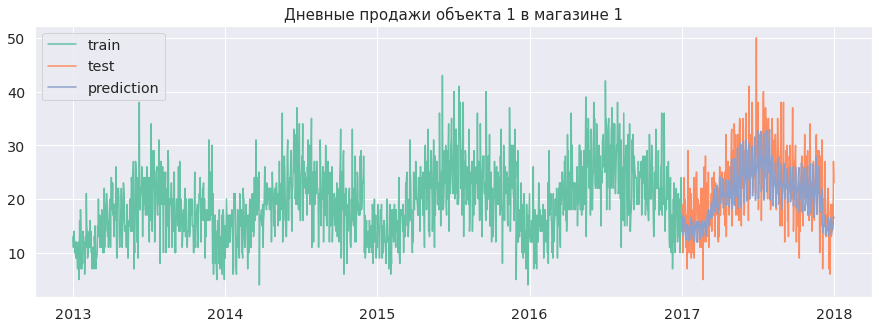

In [ ]:
cv_shifted_features_random_forest = rf_random.best_estimator_
cv_shifted_features_random_forest_predictions = recursive_prediction(
    cv_shifted_features_random_forest, 
    data_test.index, 
    data_train, 
    date_and_shift_features_generator_for_test
)
plot_results(
    data_train, 
    data_test, 
    cv_shifted_features_random_forest_predictions, 
)

In [ ]:
add_results_in_comparison_table('RandomForest + shift features + cv', 
                                data_test, cv_shifted_features_random_forest_predictions)

,method,MSE,MAE,MAPE
0,Simple mean model,34.553044,4.696804,21.794923
1,RandomForest,28.391523,4.211826,21.315196
2,XGBoost,29.840906,4.426807,22.585702
3,RandomForest + shift features,26.486008,4.081836,19.712467
4,XGBoost + shift features,27.043359,4.162855,21.213755
5,"RandomForest, advanced features",26.292108,4.057918,19.587309
6,"XGBoost, advanced features",27.605066,4.060974,20.211705
7,RandomForest + shift features + cv,25.067079,3.985490,19.529712


### Заключение
В данном ноутбуке было показано, как предсказывать временные ряды с помощью методов регрессии машинного обучения. Из проведенного исследования можно сделать несколько выводов.

1) Добавление исторических даннных (с помощью операции shift) может улучшить предсказание.

2) Не всегда больше признаков, значит лучше.

3) До экспериментов трудно предсказать, какая модель даст лучший результат.

Что можно было бы еще сделать?
* Провести отбор параметров каждой из моделей.
* Все-таки добавить еще какие-то признаки, посчитанные по историческим данным. Для этого может, например, пригодиться пакет [tsfresh](https://tsfresh.readthedocs.io/en/latest/text/quick_start.html#install-tsfresh)
* Попробовать другие модели регрессии.